This notebook defines some Python function to wrap most of the command-line tools, so that we can more easily display the automata produced.  It relies on the Python bindings of Spot.  We will cover all the examples of [README.md](README.md).

In [1]:
import tempfile, os
import spot
from spot.seminator import seminator
spot.setup()

def cmdautout(aut, cmd):
    "Save aut in a temporary file and return spot.automaton(cmd.format(FILENAME))."
    with tempfile.NamedTemporaryFile(suffix='.hoa', delete=False) as t:
        t.write(aut.to_str().encode('utf-8'))
        t.close()
        try:
            return spot.automaton(cmd.format(t.name))
        finally:
            spot.aux.rm_f(t.name)
    return None

def cmdautaut(aut, cmd):
    """Save aut in a temporary file, create a temporary file for output, 
    run cmd.format(FILEIN, FILEOUT), and return spot.automaton(FILEOUT)."""
    with tempfile.NamedTemporaryFile(suffix='.hoa', delete=False) as filein:
        filein.write(aut.to_str().encode('utf-8'))
        filein.close()
        with tempfile.NamedTemporaryFile(suffix='.hoa', delete=False) as fileout:
            fileout.close()
            try:
                os.system(cmd.format(filein.name, fileout.name))
                return spot.automaton(fileout.name)
            finally:
                spot.aux.rm_f(filein.name)
                spot.aux.rm_f(fileout.name)
    return None

# Spot

Converting an LTL formula to TGBA or SBA is simple:

In [2]:
def ltl2tgba(ltl, buchi=False):
    return spot.translate(ltl, "BA" if buchi else "TGBA")

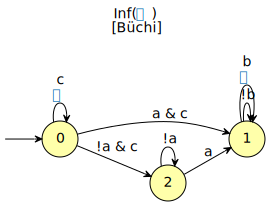

In [3]:
automaton = ltl2tgba('F(a & GFb) R c'); automaton

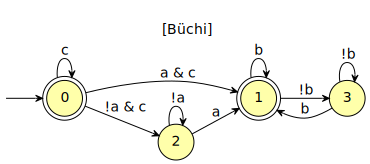

In [4]:
sba = ltl2tgba('F(a & GFb) R c', True); sba

Testing if an automaton is semi-deterministic:

In [5]:
spot.is_semi_deterministic(automaton)

False

Converting an automaton to state-based Büchi:

In [6]:
def force_buchi(aut):
    return aut.postprocess("BA")

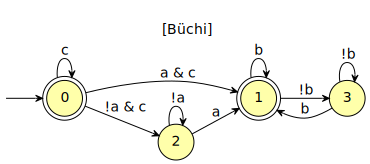

In [7]:
force_buchi(automaton)

Simplifying an automaton:

In [8]:
def simplify(aut):
    return aut.postprocess()

Complementing an automaton to TGBA:

In [9]:
def complement_to_tgba(aut):
    return spot.complement(aut).postprocess("TGBA")

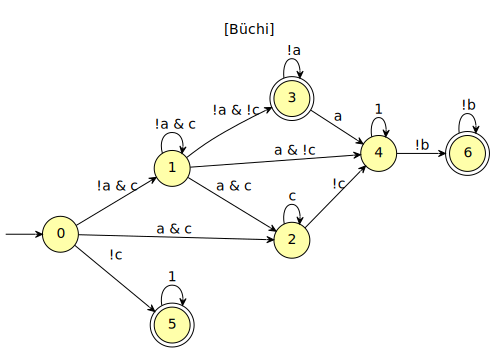

In [10]:
complement_to_tgba(automaton)

# Seminator

Default semi-determinization:

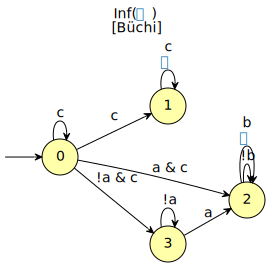

In [11]:
seminator(automaton)

The two variants of the complementation are undistinguishable on this example.  (Using `complement=True` would try both and return the smallest.)

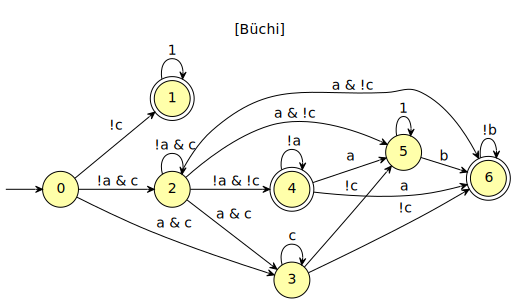

In [12]:
seminator(automaton, complement="spot")

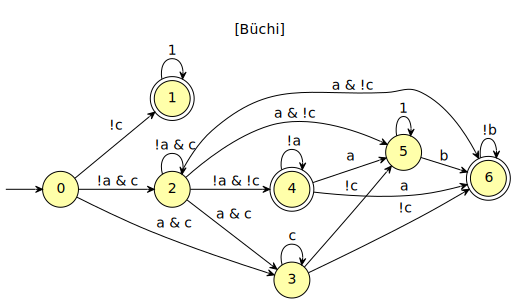

In [13]:
seminator(automaton, complement="pldi")

# Old Seminator Versions

Version 1.1 and 1.2 of seminator only support semi-determinization.

In [14]:
def seminator_1_1(aut):
    return cmdautout(aut, "seminator-1.1 {} |")
def seminator_1_2(aut):
    return cmdautout(aut, "seminator-1.2 {} |")

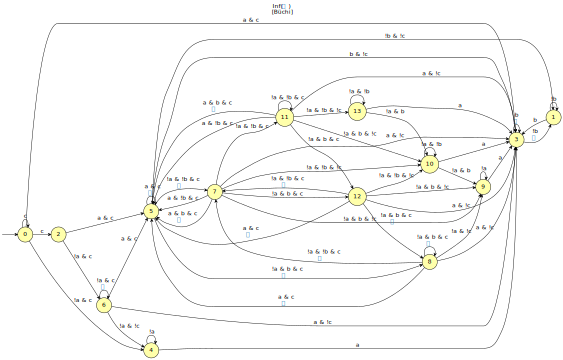

In [15]:
seminator_1_1(automaton)

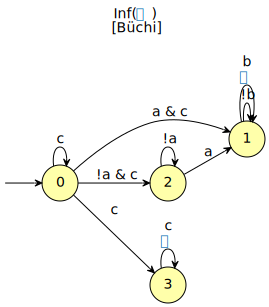

In [16]:
seminator_1_2(automaton)

# Owl

Converting an LTL formula into a semi-deterministic automaton:

In [17]:
def ltl2ldgba(ltl, symmetric=False):
    return spot.automaton("ltl2ldgba {} {:q}|".format("-s" if symmetric else "", spot.formula(ltl)))

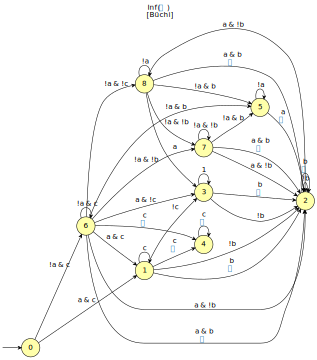

In [18]:
ltl2ldgba('F(a & GFb) R c')

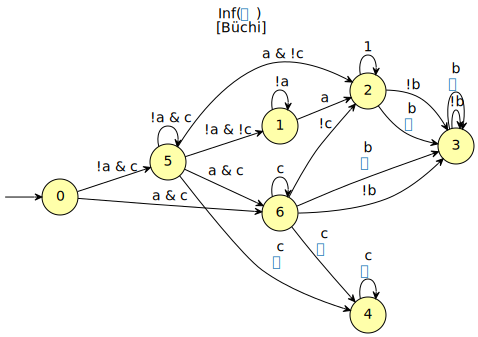

In [19]:
ltl2ldgba('F(a & GFb) R c', True)

Converting a BA into a semi-deterministic automaton:

In [20]:
def nba2ldba(aut):
    return cmdautout(aut, "nba2ldba -I {} |")

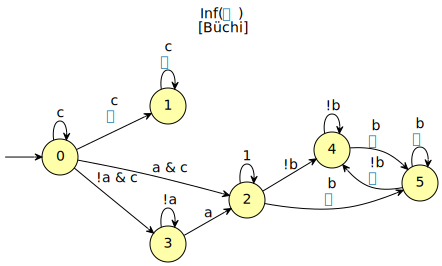

In [21]:
nba2ldba(automaton)

# ROLL / Buechic

The Buechic tool, for complementing state-based Büchi automata, has been merged in ROLL.

In [22]:
def buechic(aut):
    assert aut.acc().is_buchi() and aut.prop_state_acc()
    out = cmdautaut(sba, "roll complement {} -out {}")
    out.merge_edges()
    return out

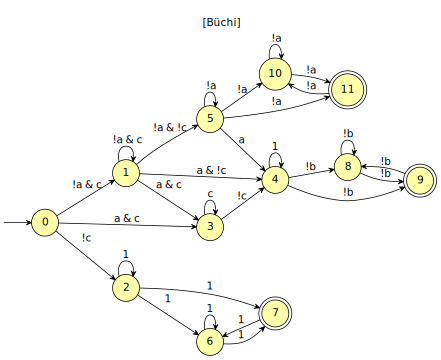

In [23]:
buechic(sba)

# Goal


The following call the two complementations we considered in the paper: the Fribourg construction, and the Piterman construction.

In [24]:
def goal_fribourg(aut):
    assert aut.acc().is_buchi() and aut.prop_state_acc()   
    return cmdautaut(aut, "gc batch '$temp = complement -m fribourg {}; save -c HOAF $temp {};'")
def goal_piterman(aut):
    assert aut.acc().is_buchi() and aut.prop_state_acc()
    return cmdautaut(aut, "gc batch '$temp = complement -m piterman -eq -sp {}; save -c HOAF $temp {};'")

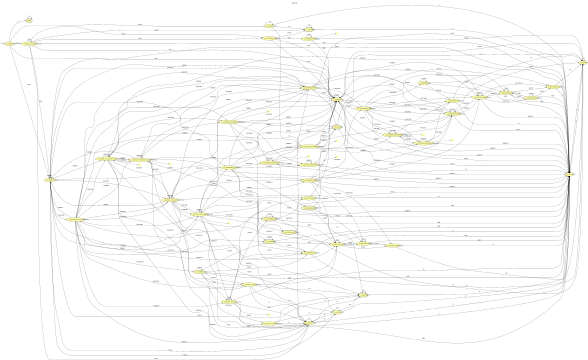

In [25]:
goal_fribourg(sba)

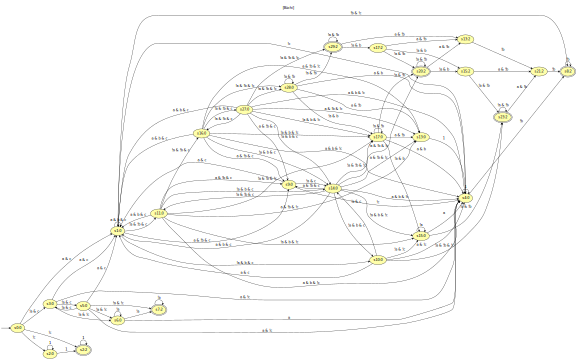

In [26]:
goal_piterman(sba)